### Purpose of This Notebook

This notebook is meant to provide you with an example solution to the Guided Project for the Introduction to the Deep Learning in PyTorch course. Since the choice of data preprocessing, and model architecture are up to you, your results may be slightly different. Use this solution notebook as a guide on how you could structure or augment your own answer.

# Exploring the Data

The first step in any data science project is getting familiar with the dataset. We're working with historical Indian IPO data to build a model that can predict whether an IPO will have listing gains.

Before jumping into any analysis or modeling, it's important to understand what we're working with. This means checking the basic structure of the data, looking for any obvious issues like missing values, and getting a sense of the distributions we're dealing with.

The `Listing_Gains_Percent` column is particularly important since it will become the foundation for our binary classification target. We want to understand its range and distribution before we transform it into a binary variable.

Let's start off by importing all the libraries we'll need for this solution.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import copy

In [2]:
df = pd.read_csv('Indian_IPO_Market_Data.csv')

print("First 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())

print(f"We have {df.shape[0]} IPOs and {df.shape[1]} columns")

print("\nColumn information:")
df.info()

print("\nTarget variable (Listing_Gains_Percent) summary:")
print(df['Listing_Gains_Percent'].describe())

print("\nSummary statistics for all numeric columns:")
print(df.describe())

First 5 rows:
      Date           IPOName  Issue_Size  Subscription_QIB  Subscription_HNI  \
0  03/02/10    Infinite Comp      189.80             48.44            106.02   
1  08/02/10    Jubilant Food      328.70             59.39             51.95   
2  15/02/10    Syncom Health       56.25              0.99             16.60   
3  15/02/10  Vascon Engineer      199.80              1.12              3.65   
4  19/02/10      Thangamayil        0.00              0.52              1.52   

   Subscription_RII  Subscription_Total  Issue_Price  Listing_Gains_Percent  
0             11.08               43.22          165                  11.82  
1              3.79               31.11          145                 -84.21  
2              6.25                5.17           75                  17.13  
3              0.62                1.22          165                 -11.28  
4              2.26                1.12           75                  -5.20  

Last 5 rows:
        Date           

No missing values across 319 IPOs means we can focus on modeling instead of data cleaning headaches.

Our `Listing_Gains_Percent` has a mean of 4.7% but a huge standard deviation of 47.7%. Translation: IPO performance is all over the place, from crashes of -97% to massive gains of 270%. That's the volatile nature of IPO markets.

Notice the median (1.8%) is much lower than the mean (4.7%). This means we have some big winners pulling the average up, while many IPOs had modest or negative returns.

Our features look promising. We have subscription data from different investor types, issue sizes, and pricing info. The subscription numbers vary wildly too, which makes sense since market demand drives IPO success.

For our binary classification approach, this variation is actually perfect. We'll need to pick a threshold to split continuous gains into binary labels, and the data suggests even a simple "positive vs negative" split could work well since roughly half the IPOs had minimal gains.

Bottom line: we have clean, meaningful data with enough variation to build a solid classifier.

## Creating Binary Labels

Right now we have `Listing_Gains_Percent` as a continuous variable, but what we really want to predict is much simpler: will this IPO make money or not? Yes or no? `1` or `0`?

Think about it from an investor's perspective. They don't need to know if an IPO will gain exactly 15.7% or 23.2%. They just want to know: "Should I put my money here?" This makes this dataset perfect for binary classification.

We're basically drawing a line at zero percent gains in the `Listing_Gains_Percent` column. Anything above that line is a "yes, invest" (`1`) and anything at or below is a "no, skip it" (`0`). Even a tiny 0.1% gain means they make money, while a 0% gain means they break even (which isn't great when you factor in transaction costs and opportunity cost).

In [3]:
df['Listing_Gains_Profit'] = (df['Listing_Gains_Percent'] > 0).astype(int)

print("First few rows showing original vs binary target:")
print(df[['Listing_Gains_Percent', 'Listing_Gains_Profit']].head(10))

First few rows showing original vs binary target:
   Listing_Gains_Percent  Listing_Gains_Profit
0                  11.82                     1
1                 -84.21                     0
2                  17.13                     1
3                 -11.28                     0
4                  -5.20                     0
5                 -88.88                     0
6                  -2.69                     0
7                 -36.33                     0
8                 -82.68                     0
9                  63.62                     1


## Understanding Target Variable Distribution

This is where we get our first real insight into the Indian IPO market. The distribution of our target variable tells us whether we're dealing with a rare event (like finding a unicorn startup) or something more balanced.

In [4]:
print("Distribution of IPO profitability:")
target_counts = df['Listing_Gains_Profit'].value_counts()
print(target_counts)

target_percentages = df['Listing_Gains_Profit'].value_counts(normalize=True) * 100
print(f"\nAs percentages:")
print(f"Profitable IPOs (1): {target_percentages[1]:.1f}%")
print(f"Non-profitable IPOs (0): {target_percentages[0]:.1f}%")

profitable_percentage = (df['Listing_Gains_Profit'] == 1).mean() * 100
print(f"\nExact percentage of profitable IPOs: {profitable_percentage:.2f}%")

Distribution of IPO profitability:
Listing_Gains_Profit
1    174
0    145
Name: count, dtype: int64

As percentages:
Profitable IPOs (1): 54.5%
Non-profitable IPOs (0): 45.5%

Exact percentage of profitable IPOs: 54.55%


### Business Context and Implications

The distribution of profitable vs non-profitable IPOs tells us a lot about market conditions and investor behavior.

If the majority of IPOs are profitable, that suggests a generally bullish market where investors are optimistic and willing to bid up new listings. If it's more balanced or skewed toward losses, that might indicate more cautious market conditions or that many companies are going public at inflated valuations.

This target distribution also affects our modeling strategy. If we have a severe class imbalance (like 90% profitable or 10% profitable), we might need to consider techniques like stratified sampling to make sure our model learns patterns from both classes effectively.

In [5]:
print("Comparison of profitable vs non-profitable IPOs:")
print(f"\nProfitable IPOs - Average listing gain: {df[df['Listing_Gains_Profit']==1]['Listing_Gains_Percent'].mean():.2f}%")
print(f"Non-profitable IPOs - Average listing loss: {df[df['Listing_Gains_Profit']==0]['Listing_Gains_Percent'].mean():.2f}%")

print(f"\nLargest gain: {df['Listing_Gains_Percent'].max():.2f}%")
print(f"Largest loss: {df['Listing_Gains_Percent'].min():.2f}%")

Comparison of profitable vs non-profitable IPOs:

Profitable IPOs - Average listing gain: 33.99%
Non-profitable IPOs - Average listing loss: -30.36%

Largest gain: 270.40%
Largest loss: -97.15%


## Preparing the Feature Set

Not every column in our dataset should be used for prediction. Some columns are just not helpful (like the IPO name), while others would be cheating (like using the original listing gains percentage to predict our binary version).

In [6]:
print("All columns in the dataset:")
print(list(df.columns))

# Columns we should exclude:
# - 'Date ': Specific dates aren't great predictors (though day of week might be interesting; notice the space at the end)
# - 'IPOName': Company names don't generalize well to new IPOs
# - 'Listing_Gains_Percent': This is what we used to create our target - using it would be cheating!
# - 'Listing_Gains_Profit': This IS our target variable

exclude_columns = ['Date ', 'IPOName', 'Listing_Gains_Percent', 'Listing_Gains_Profit']
potential_features = [col for col in df.columns if col not in exclude_columns]

print(f"\nPotential feature columns: {potential_features}")
print(f"Number of features: {len(potential_features)}")

All columns in the dataset:
['Date ', 'IPOName', 'Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total', 'Issue_Price', 'Listing_Gains_Percent', 'Listing_Gains_Profit']

Potential feature columns: ['Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total', 'Issue_Price']
Number of features: 6


## Visual Data Exploration

We're about to dig into our data visually and see what stories it tells us. This is where we go from just knowing the basic facts (319 IPOs, 54.5% profitable) to understanding what actually drives IPO success. Raw numbers are helpful, but the patterns we can see in charts and graphs will guide our modeling decisions.

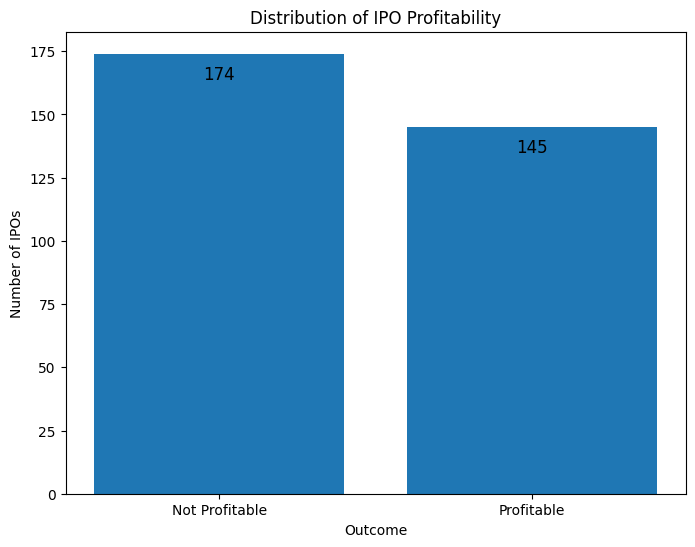

We have a fairly balanced dataset: 174 profitable vs 145 unprofitable IPOs


In [7]:
# First, let's see our target distribution visually
plt.figure(figsize=(8, 6))
target_counts = df['Listing_Gains_Profit'].value_counts()
plt.bar(['Not Profitable', 'Profitable'], target_counts.values)
plt.title('Distribution of IPO Profitability')
plt.ylabel('Number of IPOs')
plt.xlabel('Outcome')

# Add the actual numbers on top of each bar
for i, count in enumerate(target_counts.values):
    plt.text(i, count - 10, str(count), ha='center', fontsize=12)

plt.show()

print(f"We have a fairly balanced dataset: {target_counts[1]} profitable vs {target_counts[0]} unprofitable IPOs")

## Feature Distributions

Before we can build a good model, we need to understand what we're working with. Some features might be heavily skewed, others might have outliers, and some might have really wide ranges. All of this affects how our model will learn from the data.

Our potential feature columns:
- Issue_Size
- Subscription_QIB
- Subscription_HNI
- Subscription_RII
- Subscription_Total
- Issue_Price


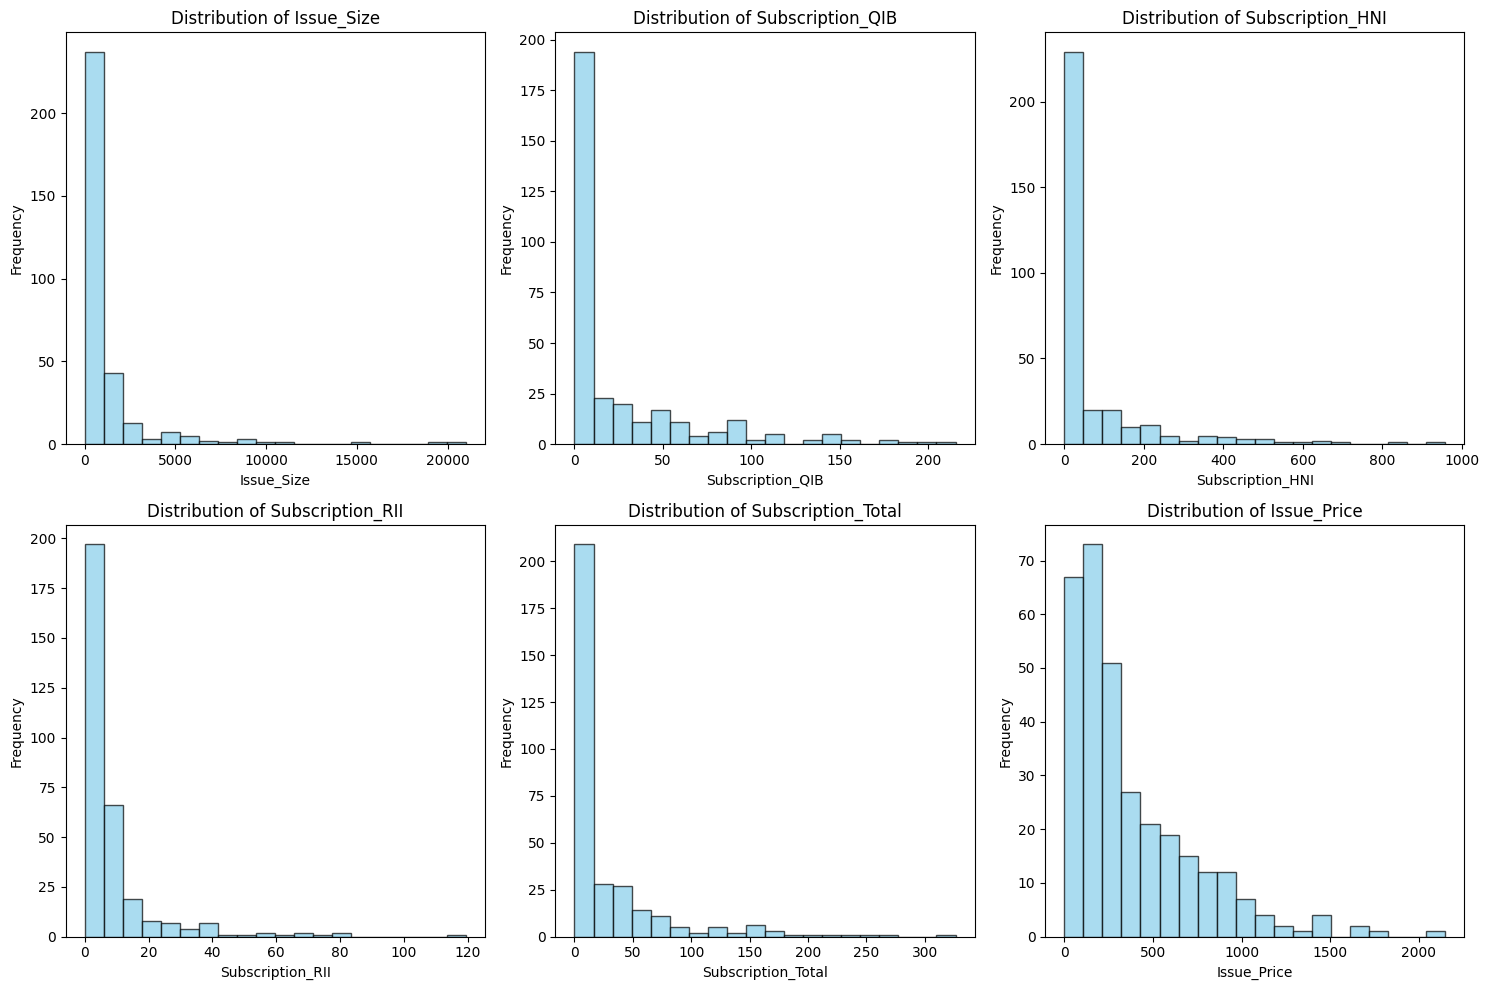

In [8]:
# Get our feature columns (excluding the ones we identified earlier)
exclude_columns = ['Date ', 'IPOName', 'Listing_Gains_Percent', 'Listing_Gains_Profit']
potential_features = [col for col in df.columns if col not in exclude_columns]

print("Our potential feature columns:")
for col in potential_features:
    print(f"- {col}")

# Let's look at the distribution of each feature
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(potential_features):
    axes[i].hist(df[column].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Looking at these distribution plots, we can see a clear story about how IPOs behave in this market.

Five of our six features show the same dramatic pattern: most values cluster heavily in that first bin on the left, then drop off sharply as we move right. This tells us that most IPOs in our dataset have relatively low subscription rates, smaller issue sizes, and modest metrics overall. The sparse bins on the right represent the few IPOs that had massive oversubscription or unusually large issue sizes.

Think about what this means: a typical IPO might get 2x or 5x subscription, but a few outliers get 50x or 100x oversubscribed. Most companies raise moderate amounts, but a few giants dominate the right side of the distribution.

`Issue_Price` shows a bit more spread, but it's still right-skewed. Most IPOs price themselves in the lower to mid range, with fewer companies commanding premium pricing.

This kind of distribution can create a challenge for our model. Those extreme values on the right could dominate the learning process, making the model focus too much on rare outliers instead of learning the patterns that apply to most IPOs. The model might think that only massively oversubscribed IPOs succeed, missing the subtler patterns in the typical cases.

But that's okay because we're going to scale our data, which will put all features on the same playing field and prevent those outliers from overwhelming our model's learning process.

## How Do Features Relate to IPO Success?

This is where things get really interesting. We want to see if profitable IPOs look different from unprofitable ones across our features. Maybe profitable IPOs tend to be larger, or maybe they have higher subscription rates from certain investor types.

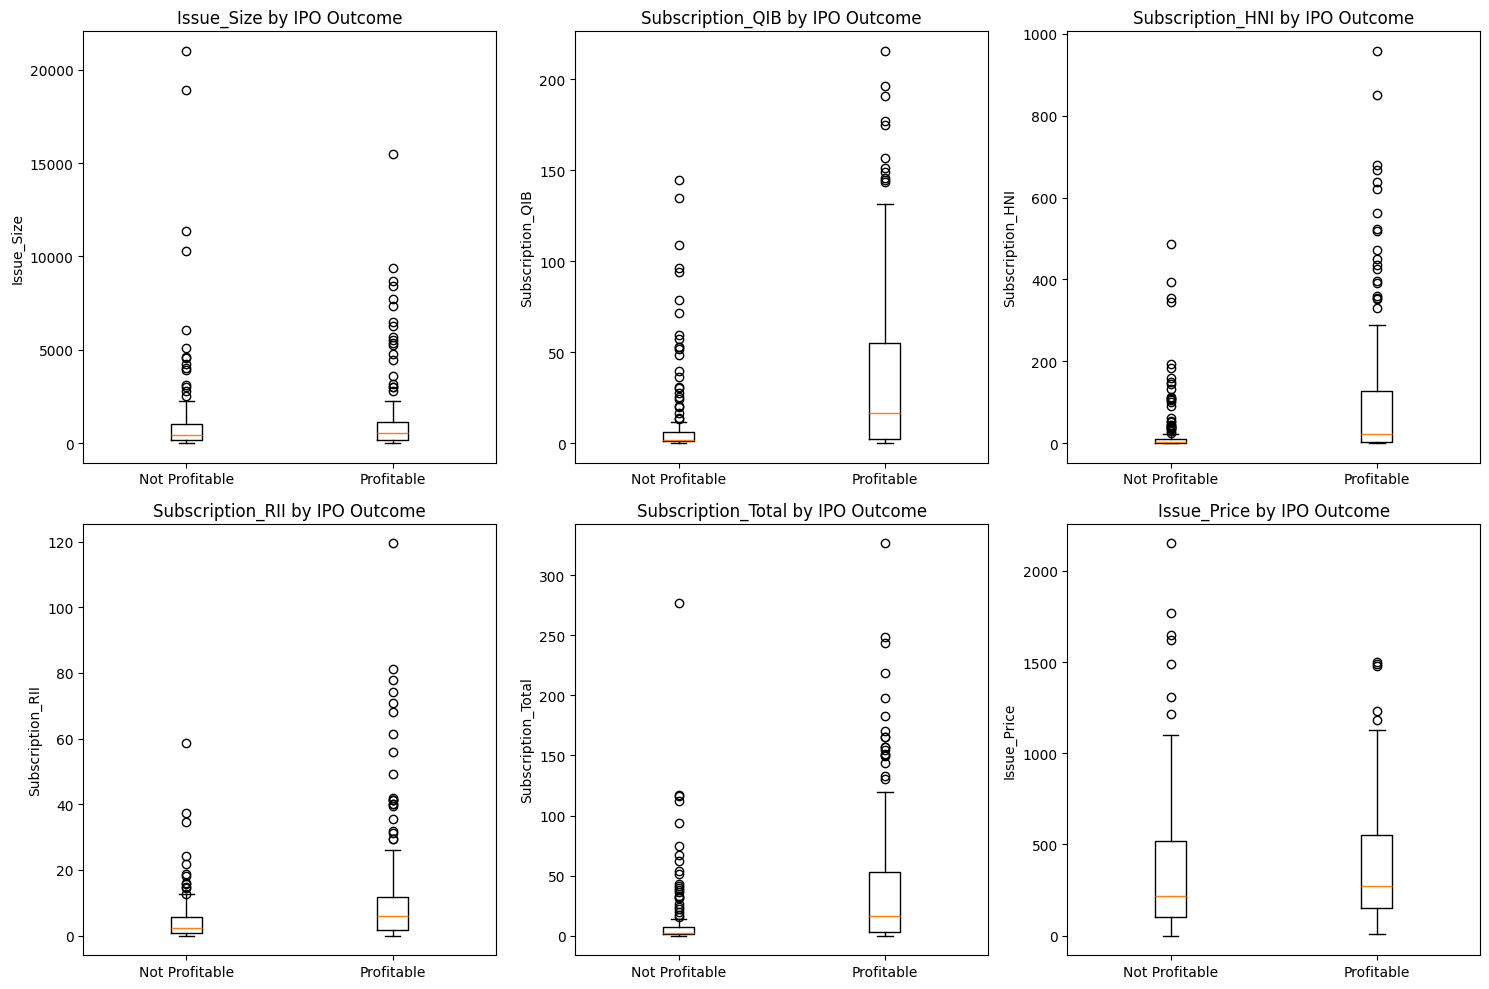

In [9]:
# Let's compare profitable vs non-profitable IPOs across all features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(potential_features):
    # Create box plots to compare the two groups
    profitable_data = df[df['Listing_Gains_Profit'] == 1][column]
    not_profitable_data = df[df['Listing_Gains_Profit'] == 0][column]

    axes[i].boxplot([not_profitable_data.dropna(), profitable_data.dropna()],
                    tick_labels=['Not Profitable', 'Profitable'])
    axes[i].set_title(f'{column} by IPO Outcome')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

Looking at these boxplots, we're seeing our first real clues about what separates successful IPOs from the rest.

`Issue_Size` tells us something surprising: it doesn't really matter how big the IPO is. Both profitable and non-profitable IPOs have their boxes clustered at similar low levels, with similar outliers scattered above. Big doesn't necessarily mean better in this market.

The subscription metrics paint a completely different picture. Across all three investor types (QIB, HNI, and RII), profitable IPOs consistently show higher subscription rates. Those boxes sit noticeably higher for the profitable group, and `Subscription_Total` confirms this pattern since it combines all investor categories.

This makes perfect sense when we think about it. Subscription rates capture real market sentiment before the IPO even hits the market. When investors are excited enough to oversubscribe, they're essentially voting with their money that this company has potential.

`Issue_Price` shows both groups clustering around similar ranges, suggesting that expensive or cheap pricing alone isn't the deciding factor. It's not about how much you charge, but whether people actually want what you're selling.

The takeaway here is clear: market demand before listing seems to predict performance after listing. This gives us confidence that our features contain real predictive signals that a model can learn to recognize. The patterns we're seeing aren't random, they're telling a story about investor behavior and market dynamics.

## Looking for Feature Relationships

Sometimes features are related to each other in ways that can trip up our models. If two features basically measure the same thing, including both might not help and could even hurt performance. A correlation heatmap shows us these relationships at a glance.

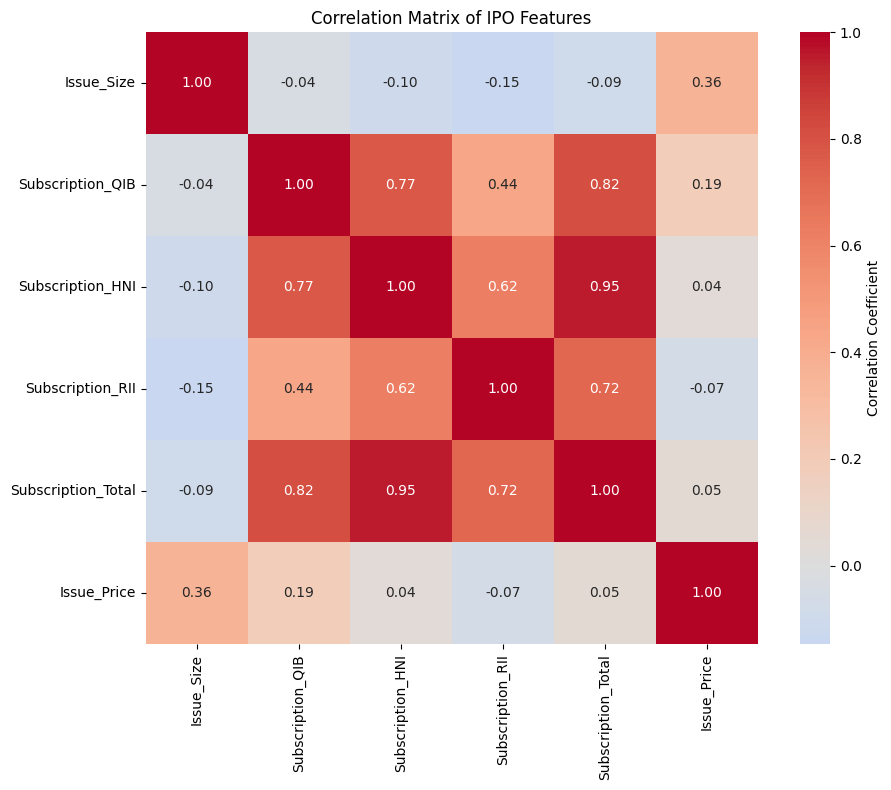

Correlation with IPO Profitability:
Subscription_QIB      0.323499
Subscription_Total    0.283340
Subscription_HNI      0.271879
Subscription_RII      0.240842
Issue_Price           0.039548
Issue_Size            0.004717
Name: Listing_Gains_Profit, dtype: float64


In [10]:
# Calculate correlations between all numeric features
numeric_features = df[potential_features].select_dtypes(include=[np.number])
correlation_matrix = numeric_features.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of IPO Features')
plt.tight_layout()
plt.show()

# Let's also look at which features correlate most with our target
target_correlations = df[potential_features + ['Listing_Gains_Profit']].corr()['Listing_Gains_Profit'].sort_values(ascending=False)
print("Correlation with IPO Profitability:")
print(target_correlations[1:])  # Exclude the target's correlation with itself

Looking at the correlation heatmap, we can see how our features relate to each other, and it reveals some important patterns we need to address.

That big cluster of red in the subscription section shows us strong correlations between the different subscription metrics, especially that `0.95` correlation between `Subscription_HNI` and `Subscription_Total`. This is multicollinearity at work, where features are so similar that they're essentially telling our model the same story multiple times.

The correlation rankings with IPO profitability tell us a different story. Here we see that subscription metrics dominate the top positions, with `Subscription_QIB` leading at `0.32`, while `Issue_Price` (`0.04`) and `Issue_Size` show very weak relationships with success.

Now, you might think we should just dump those poorly correlated features, but that would be a mistake. Correlation only captures linear relationships between individual features and our target. Our neural network can find much more complex patterns, especially interactions between features. Maybe small IPOs behave completely differently than large ones when they get high subscription rates. Maybe pricing matters more for certain types of companies. These nuanced patterns won't show up in simple correlation calculations, but they could be exactly what makes our model successful.

That all said, we do need to tackle that multicollinearity problem. Since `Subscription_Total` is literally just the sum of the individual subscription components, we'll drop it and keep the individual metrics instead. This preserves the detailed information about different investor types while eliminating the redundancy that could confuse our model.

Our final `feature_columns` set gives us the best of both worlds: `Subscription_QIB`, `Subscription_HNI`, `Subscription_RII`, `Issue_Price`, `Issue_Size`. Five focused features that each bring unique information to help our model understand what drives IPO success.

In [11]:
feature_columns = ['Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Issue_Price', 'Issue_Size'] 

# Setting Up the Data for  Training

Alright, time to get our data ready for the real work! We've explored it, understood it, and decided on our approach. Based on our correlation analysis, we're moving forward with five carefully selected features. We dropped `Subscription_Total` to avoid multicollinearity issues while keeping the features that give us unique insights into different aspects of IPO performance.

Our target variable is already converted to binary labels where `1` means profitable and `0` means not profitable. Now we need to split everything up properly for training.

In [12]:
# Create our feature matrix (X) and target vector (y)
X = df[feature_columns].copy()
y = df['Listing_Gains_Profit'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Feature matrix shape: (319, 5)
Target vector shape: (319,)


## Splitting the Data

Time to divide up our data for training. We'll use the two-step approach you're familiar with: first set aside our test data that we won't touch until the very end, then split what remains between training and validation sets. The key is using stratified sampling so each split maintains that 55% profitable ratio we saw in our original data.

In [13]:
# Step 1: Split off our test set (20% of total data)
# The stratify parameter ensures our test set has the same target distribution
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"After first split:")
print(f"  Temp data (train+val): {X_temp.shape[0]} samples")
print(f"  Test data: {X_test.shape[0]} samples")
print(f"  Test target distribution: {y_test.mean():.1%} profitable")

# Step 2: Split the remaining data into train (75%) and validation (25%)
# This gives us 60% and 20% of the original data respectively
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 25% of remaining 80% = 20% of original
    stratify=y_temp,
    random_state=42
)

print(f"Final split breakdown:")
print(f"  Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(df):.1%})")
print(f"  Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(df):.1%})")
print(f"  Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(df):.1%})")

print(f"\nTarget distributions:")
print(f"  Training: {y_train.mean():.1%} profitable")
print(f"  Validation: {y_val.mean():.1%} profitable")
print(f"  Test: {y_test.mean():.1%} profitable")

After first split:
  Temp data (train+val): 255 samples
  Test data: 64 samples
  Test target distribution: 54.7% profitable
Final split breakdown:
  Training: 191 samples (59.9%)
  Validation: 64 samples (20.1%)
  Test: 64 samples (20.1%)

Target distributions:
  Training: 54.5% profitable
  Validation: 54.7% profitable
  Test: 54.7% profitable


## Scaling the Features

We saw that our features are on wildly different scales. Issue sizes are in the thousands while subscription rates might be single digits. We need to standardize everything so our model can learn effectively from all features equally.

The critical part here is that we fit our scaler only on the training data, then apply those same scaling parameters to validation and test sets. This mimics real-world conditions where you'd only know about historical data when scaling new IPOs for prediction.

In [14]:
# Initialize our scaler
scaler = StandardScaler()

# THE CRUCIAL PART: Fit only on training data
scaler.fit(X_train)

print("Scaling parameters learned from training data:")
print(f"  Feature means: {scaler.mean_}")
print(f"  Feature standard deviations: {scaler.scale_}")

# Now transform all our datasets using the SAME scaling parameters
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames to keep our column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)

print("Scaled dataset shapes:")
print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  X_val_scaled: {X_val_scaled.shape}")
print(f"  X_test_scaled: {X_test_scaled.shape}")

Scaling parameters learned from training data:
  Feature means: [  26.4952356    73.29701571    8.02041885  380.59162304 1071.6808377 ]
  Feature standard deviations: [  41.48012514  148.75074      12.11881169  348.99351279 2084.1555454 ]
Scaled dataset shapes:
  X_train_scaled: (191, 5)
  X_val_scaled: (64, 5)
  X_test_scaled: (64, 5)


## Quick Data Verification

Let's make sure our scaling worked as expected. Our training data should now have means around 0 and standard deviations around 1. The validation and test sets will have slightly different numbers since they're using the training data's scaling parameters, which is exactly what we want for realistic model evaluation.

In [15]:
print("Training data after scaling (should be ~0 mean, ~1 std):")
print(f"  Means: {X_train_scaled.mean().round(3).values}")
print(f"  Standard deviations: {X_train_scaled.std().round(3).values}")

print(f"\nValidation data after scaling (will be slightly different):")
print(f"  Means: {X_val_scaled.mean().round(3).values}")

print(f"\nTest data after scaling (will be slightly different):")
print(f"  Means: {X_test_scaled.mean().round(3).values}")

print(f"\nEverything looks good! We're ready to start building our PyTorch model.")

Training data after scaling (should be ~0 mean, ~1 std):
  Means: [0. 0. 0. 0. 0.]
  Standard deviations: [1.003 1.003 1.003 1.003 1.003]

Validation data after scaling (will be slightly different):
  Means: [-0.026 -0.114  0.069 -0.243  0.025]

Test data after scaling (will be slightly different):
  Means: [-0.071  0.007  0.154  0.165  0.265]

Everything looks good! We're ready to start building our PyTorch model.


## Converting to PyTorch Tensors

Time to translate our data into PyTorch's native language. PyTorch works with tensors instead of pandas DataFrames, so we need to make that conversion. We'll use `float32` since that's PyTorch's preferred data type for neural network operations.

In [16]:
# First, let's convert our scaled data to PyTorch tensors
# PyTorch prefers float32 for most operations, especially for neural networks

X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

print("Tensor shapes:")
print(f"  X_train: {X_train_tensor.shape}")
print(f"  y_train: {y_train_tensor.shape}")
print(f"  X_val: {X_val_tensor.shape}")
print(f"  y_val: {y_val_tensor.shape}")
print(f"  X_test: {X_test_tensor.shape}")
print(f"  y_test: {y_test_tensor.shape}")

Tensor shapes:
  X_train: torch.Size([191, 5])
  y_train: torch.Size([191])
  X_val: torch.Size([64, 5])
  y_val: torch.Size([64])
  X_test: torch.Size([64, 5])
  y_test: torch.Size([64])


## Creating Datasets

Now we need to pair up our features with their corresponding targets. TensorDataset is perfect for this - it basically creates a collection where each item contains both the features and the target for one IPO.

In [17]:
# Create datasets that pair features with targets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

print(f"Created datasets:")
print(f"  Training dataset: {len(train_dataset)} samples")
print(f"  Validation dataset: {len(val_dataset)} samples")
print(f"  Test dataset: {len(test_dataset)} samples")

# Let's peek at what one sample looks like
sample_features, sample_target = train_dataset[0]
print(f"\nSample from training dataset:")
print(f"  Features shape: {sample_features.shape}")
print(f"  Target: {sample_target.item()}")

Created datasets:
  Training dataset: 191 samples
  Validation dataset: 64 samples
  Test dataset: 64 samples

Sample from training dataset:
  Features shape: torch.Size([5])
  Target: 1.0


## Setting Up DataLoaders

Here's where the magic happens! DataLoaders handle all the messy details of feeding data to our model in nice, manageable chunks. We're using a batch size of 16, which is small enough to fit comfortably in memory but large enough to give us stable gradient updates.

The key difference between training and validation loaders is shuffling. We shuffle training data so our model sees different combinations of IPOs in each epoch, which helps it learn better patterns. But we don't shuffle validation data because we want consistent, reproducible results when we're evaluating performance.

In [18]:
# Set up our data loaders
# Training loader: shuffle=True to mix things up each epoch
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Validation loader: shuffle=False for consistent evaluation
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Test loader: we'll use this later for final evaluation
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("DataLoaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

DataLoaders created:
  Training batches: 12
  Validation batches: 4
  Test batches: 4


## Verifying Everything Works

Let's make sure our data pipeline is working correctly by grabbing a batch and seeing what it looks like. This is always a good sanity check before we start training.

In [19]:
# Get a sample batch from the training loader
for batch_features, batch_targets in train_loader:
    print("Sample training batch:")
    print(f"  Batch features shape: {batch_features.shape}")
    print(f"  Batch targets shape: {batch_targets.shape}")
    print(f"  Features dtype: {batch_features.dtype}")
    print(f"  Targets dtype: {batch_targets.dtype}")

    # Show the actual target values in this batch
    print(f"  Target values in batch: {batch_targets.tolist()}")
    print(f"  Profitable IPOs in batch: {(batch_targets == 1).sum().item()}/{len(batch_targets)}")
    break  # Just look at the first batch

print(f"\nPerfect! With {len(train_loader)} training batches and {len(val_loader)} validation batches,")
print(f"we're ready to start building our neural network.")

Sample training batch:
  Batch features shape: torch.Size([16, 5])
  Batch targets shape: torch.Size([16])
  Features dtype: torch.float32
  Targets dtype: torch.float32
  Target values in batch: [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
  Profitable IPOs in batch: 8/16

Perfect! With 12 training batches and 4 validation batches,
we're ready to start building our neural network.


# Neural Network Architecture

Time to build the brain of our operation! This is honestly one of the most rewarding parts because you get to make some creative decisions about how your model will process information.

We're building a decision-making system that needs to look at 5 different pieces of information about an IPO (our features) and somehow combine them into a single yes/no answer. The magic happens in those hidden layers, where the network learns to find patterns and relationships we might never have thought of ourselves.

We'll use the funnel approach where we start wide to capture lots of different patterns, then gradually narrow down as we focus on the most important signals.

In [20]:
# First, let's figure out our input size
input_size = X_train_tensor.shape[1]  # Number of features
print(f"Our model needs to handle {input_size} input features")

# Now let's build our neural network
# I'm going with a 4-layer architecture: input → 64 → 32 → 16 → 1
model = nn.Sequential(
    # First hidden layer: from input features to 64 neurons
    nn.Linear(input_size, 64),
    nn.ReLU(),

    # Second hidden layer: 64 to 32 (starting to funnel down)
    nn.Linear(64, 32),
    nn.ReLU(),

    # Third hidden layer: 32 to 16 (continuing the funnel)
    nn.Linear(32, 16),
    nn.ReLU(),

    # Output layer: 16 to 1 (our final prediction)
    nn.Linear(16, 1),
    nn.Sigmoid()  # Sigmoid gives us a probability between 0 and 1
)

print("Model created successfully!")
print(model)

Our model needs to handle 5 input features
Model created successfully!
Sequential(
  (0): Linear(in_features=5, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=1, bias=True)
  (7): Sigmoid()
)


## Inspecting the Model

Let's take a step back and see what we've created. Each linear layer is basically a collection of neurons that take inputs, multiply them by learned weights, add biases, and pass the result through an activation function.

The ReLU activation is doing something really important - it's adding non-linearity to our model. Without it, no matter how many layers we stack, we'd essentially have a fancy linear regression. ReLU lets our network learn complex, curved relationships between our features and IPO success.

In [21]:
# Let's see how many parameters our model has to learn
total_params = sum(param.numel() for param in model.parameters())
trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Break down by layer to see where the complexity is
print("\nParameter breakdown by layer:")
for i, layer in enumerate(model):
    if isinstance(layer, nn.Linear):
        layer_params = sum(param.numel() for param in layer.parameters())
        print(f"  Layer {i} (Linear): {layer_params:,} parameters")

Total parameters: 3,009
Trainable parameters: 3,009

Parameter breakdown by layer:
  Layer 0 (Linear): 384 parameters
  Layer 2 (Linear): 2,080 parameters
  Layer 4 (Linear): 528 parameters
  Layer 6 (Linear): 17 parameters


## Testing the Model Structure

Before we start training, let's make sure our model can actually process our data correctly. This is like doing a test run to make sure all the pipes are connected properly.

In [22]:
# Let's test our model with a small batch of data
model.eval()  # Put in evaluation mode for testing
with torch.no_grad():  # Don't compute gradients for this test
    # Get a sample batch from our training loader
    for batch_features, batch_targets in train_loader:
        # Pass the batch through our model
        test_outputs = model(batch_features)

        print(f"Input batch shape: {batch_features.shape}")
        print(f"Output batch shape: {test_outputs.shape}")
        print(f"Sample predictions: {test_outputs.squeeze()[:5].tolist()}")
        print(f"Sample actual targets: {batch_targets[:5].tolist()}")
        break

print(f"\nPerfect! Our model can process batches of {batch_features.shape[0]} IPOs")
print(f"and produce probability predictions between 0 and 1.")

Input batch shape: torch.Size([16, 5])
Output batch shape: torch.Size([16, 1])
Sample predictions: [0.4831303656101227, 0.4837856590747833, 0.4836174547672272, 0.4852580726146698, 0.4893537759780884]
Sample actual targets: [0.0, 1.0, 1.0, 1.0, 0.0]

Perfect! Our model can process batches of 16 IPOs
and produce probability predictions between 0 and 1.


### What These Initial Predictions Mean

Notice how all our untrained model's predictions cluster around `0.47`-0.`48`? That's not random. When PyTorch initializes your model's weights, those small random values combine to create a subtle bias. Right now, our model is slightly pessimistic about IPO success without any real knowledge to back it up.

This gives us a perfect baseline to watch learning happen. As training progresses, you'll see these predictions start to separate. The model will learn to push predictions above `0.5` for actually profitable IPOs and below `0.5` for the unsuccessful ones. It's like watching someone go from making uninformed guesses to developing real expertise about what makes an IPO succeed.

This starting point also confirms our model is working properly. Random predictions near `0.5` are exactly what we want from an untrained binary classifier.

# Training the IPO Prediction Model

Alright, this is where things get exciting! We're about to watch our model learn how to predict IPO success from scratch. It's going to start out pretty clueless, making random guesses, but over the next 100 epochs it should gradually get better and better at spotting the patterns in our data.

In [23]:
# Set up our loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for our yes/no predictions
optimizer = optim.Adam(model.parameters(), lr=0.00075)

# Lists to track our progress
train_accuracies = []
val_accuracies = []

## The Main Training Loop

Each epoch, our model will see every training example, make predictions, calculate how wrong it was, and then adjust itself to do better next time. After each epoch, we'll check how it's doing on both the training data and the validation data.

In [24]:
num_epochs = 100

for epoch in range(num_epochs):
    # Training phase - model learns from data
    model.train()

    for batch_features, batch_targets in train_loader:
        # The five essential steps
        optimizer.zero_grad()                            # Clear old gradients
        outputs = model(batch_features).squeeze()        # Forward pass
        loss = criterion(outputs, batch_targets)         # Calculate loss
        loss.backward()                                  # Backward pass
        optimizer.step()                                 # Update weights

    # Evaluation phase - see how we're doing
    model.eval()
    with torch.no_grad():
        # Check training accuracy
        train_outputs = model(X_train_tensor).squeeze()
        train_predictions = (train_outputs > 0.5).float()
        train_accuracy = (train_predictions == y_train_tensor).float().mean().item() * 100

        # Check validation accuracy
        val_correct = 0
        val_total = 0
        for val_features, val_targets in val_loader:
            val_outputs = model(val_features).squeeze()
            val_predictions = (val_outputs > 0.5).float()
            val_correct += (val_predictions == val_targets).sum().item()
            val_total += val_targets.size(0)
        val_accuracy = (val_correct / val_total) * 100

        # Save our accuracies for plotting
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

print("Training complete!")
print(f"Final training accuracy: {train_accuracies[-1]:.1f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.1f}%")

Training complete!
Final training accuracy: 80.1%
Final validation accuracy: 60.9%


## Visualizing the Learning Process

Now let's see how our model learned over time. This plot will tell us a lot about whether our training went well or if we ran into any issues like overfitting.

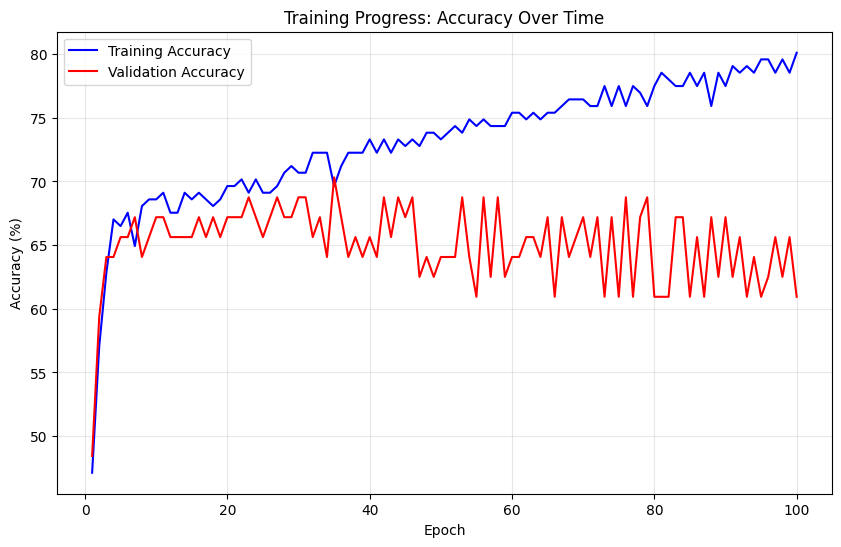

Best validation accuracy: 70.3% (achieved at epoch 35)
Final gap between training and validation: 19.2 percentage points
⚠️ Large gap suggests possible overfitting - validation accuracy much lower than training


In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Progress: Accuracy Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Let's also see the best performance we achieved
best_val_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_accuracy) + 1

print(f"Best validation accuracy: {best_val_accuracy:.1f}% (achieved at epoch {best_epoch})")

# Check for potential overfitting
final_gap = train_accuracies[-1] - val_accuracies[-1]
print(f"Final gap between training and validation: {final_gap:.1f} percentage points")

if final_gap > 10:
    print("⚠️ Large gap suggests possible overfitting - validation accuracy much lower than training")
elif final_gap < 5:
    print("✅ Small gap suggests good generalization - model performs similarly on both sets")
else:
    print("🤔 Moderate gap - model might benefit from some regularization")

### Understanding What Just Happened

This plot tells a really clear story about what went wrong during training. Look at how the two lines behave differently. In the first 10-15 epochs, both training and validation accuracy climb together, which is exactly what we want to see. The model is learning genuine patterns that help it perform better on both known and unknown data.

But then something changes. Around epoch 20, the training accuracy keeps climbing steadily toward 80%+ while the validation accuracy hits a ceiling and starts bouncing around erratically between 55% and 65%. This is classic overfitting behavior.

What's happening is that our model has started memorizing specific details about the training IPOs rather than learning general rules about what makes IPOs successful. It gets really good at recognizing the exact companies it trained on, but that knowledge doesn't help with new IPOs it hasn't seen before. The noisy, erratic validation curve after epoch 20 shows the model struggling to apply its overly-specific knowledge to new examples.

The good news is that we know exactly how to fix this problem. We'll build a regularized version that forces the model to learn more generalizable patterns instead of memorizing training examples.

# Fighting Overfitting with Regularization

So our first model showed some serious overfitting after 100 epochs. But that's totally normal and actually a good learning experience. Now we get to be the one who fixes the problem!

The thing about overfitting is that it's like a student who memorizes all the answers to practice tests but fails when they see new questions on a test. Our model got really good at those 191 training IPOs but couldn't handle fresh data. Time to teach it some better study habits.

In [26]:
# Let's build a much smarter version of our model
# Same architecture, but with all the regularization tricks we learned

input_size = X_train_tensor.shape[1]

reg_model = nn.Sequential(
    # First layer
    nn.Linear(input_size, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.25),

    # Second layer
    nn.Linear(64, 32),
    # nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.125),

    # Third layer
    nn.Linear(32, 16),
    # nn.BatchNorm1d(16),
    nn.ReLU(),
    # nn.Dropout(0.125),

    # Output layer: no batch norm or dropout here
    nn.Linear(16, 1),
    nn.Sigmoid()
)

print("Regularized model created!")
print(f"Total parameters: {sum(param.numel() for param in reg_model.parameters()):,}")
print(reg_model)

Regularized model created!
Total parameters: 3,137
Sequential(
  (0): Linear(in_features=5, out_features=64, bias=True)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.125, inplace=False)
  (7): Linear(in_features=32, out_features=16, bias=True)
  (8): ReLU()
  (9): Linear(in_features=16, out_features=1, bias=True)
  (10): Sigmoid()
)


## Setting Up for Smarter Training

Now we're going to be way more strategic about our training. Instead of blindly running for 100 epochs and hoping for the best, we'll use early stopping to quit while we're ahead.

In [27]:
# Same setup as before for loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(reg_model.parameters(), lr=0.0075)

# Early stopping setup
best_val_accuracy = 0
patience = 20
patience_counter = 0
best_model_state = None

# Tracking our progress
reg_train_accuracies = []
reg_val_accuracies = []

print("Setting up early stopping with patience of", patience)
print("Training will stop if validation accuracy doesn't improve for", patience, "consecutive epochs")

Setting up early stopping with patience of 20
Training will stop if validation accuracy doesn't improve for 20 consecutive epochs


In [28]:
max_epochs = 100
print(f"Starting training (up to {max_epochs} epochs with early stopping)...")

for epoch in range(max_epochs):
    # Training phase - same as before
    reg_model.train()

    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs = reg_model(batch_features).squeeze()
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

    # Evaluation phase
    reg_model.eval()
    with torch.no_grad():
        # Training accuracy
        train_outputs = reg_model(X_train_tensor).squeeze()
        train_predictions = (train_outputs > 0.5).float()
        train_accuracy = (train_predictions == y_train_tensor).float().mean().item() * 100

        # Validation accuracy
        val_correct = 0
        val_total = 0
        for val_features, val_targets in val_loader:
            val_outputs = reg_model(val_features).squeeze()
            val_predictions = (val_outputs > 0.5).float()
            val_correct += (val_predictions == val_targets).sum().item()
            val_total += val_targets.size(0)
        val_accuracy = (val_correct / val_total) * 100

        # Save our progress
        reg_train_accuracies.append(train_accuracy)
        reg_val_accuracies.append(val_accuracy)

        # Early stopping logic
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = copy.deepcopy(reg_model.state_dict())
            patience_counter = 0
            print(f"Epoch {epoch+1}: New best validation accuracy: {val_accuracy:.1f}%")
        else:
            patience_counter += 1

        # Check if we should stop early
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

# Load the best model we found
reg_model.load_state_dict(best_model_state)
print(f"Loaded best model with validation accuracy: {best_val_accuracy:.1f}%")

Starting training (up to 100 epochs with early stopping)...
Epoch 1: New best validation accuracy: 65.6%
Epoch 6: New best validation accuracy: 67.2%
Epoch 10: New best validation accuracy: 68.8%
Early stopping at epoch 30 (no improvement for 20 epochs)
Loaded best model with validation accuracy: 68.8%


# Comparing Models

Let's see how much better our regularized model performs compared to our original overfitting model.

In [29]:
print("Model Comparison:")
print(f"Original model - Final training accuracy: {train_accuracies[-1]:.1f}%")
print(f"Original model - Final validation accuracy: {val_accuracies[-1]:.1f}%")
print(f"Original model - Gap: {train_accuracies[-1] - val_accuracies[-1]:.1f} percentage points")

print(f"\nRegularized model - Final training accuracy: {reg_train_accuracies[-1]:.1f}%")
print(f"Regularized model - Final validation accuracy: {reg_val_accuracies[-1]:.1f}%")
print(f"Regularized model - Gap: {reg_train_accuracies[-1] - reg_val_accuracies[-1]:.1f} percentage points")

improvement = reg_val_accuracies[-1] - val_accuracies[-1]
print(f"\nValidation accuracy improvement: {improvement:+.1f} percentage points")

Model Comparison:
Original model - Final training accuracy: 80.1%
Original model - Final validation accuracy: 60.9%
Original model - Gap: 19.2 percentage points

Regularized model - Final training accuracy: 69.6%
Regularized model - Final validation accuracy: 65.6%
Regularized model - Gap: 4.0 percentage points

Validation accuracy improvement: +4.7 percentage points


## Visualizing the Improvement

Let's create side-by-side plots to really see the difference. This is one of those moments where a picture truly is worth a thousand words.

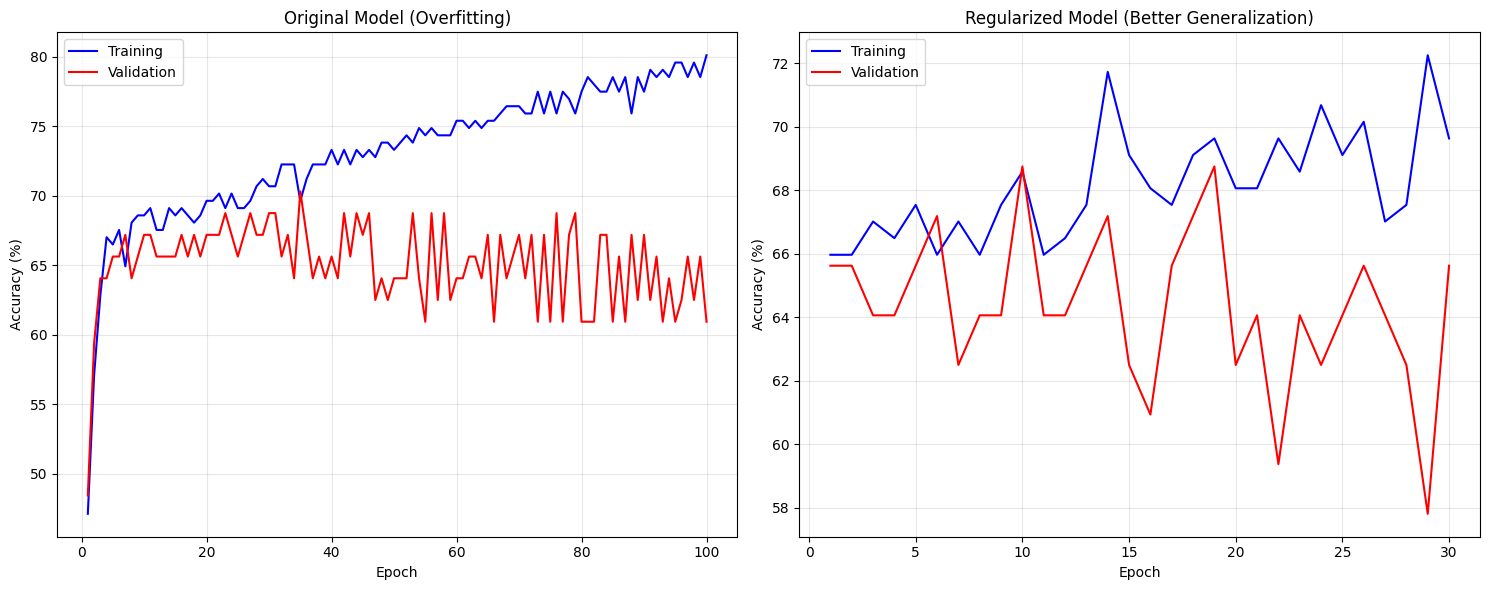

🎉 Excellent! Very small gap between training and validation accuracy

Our regularized model stopped early at epoch 30 instead of running the full 100 epochs
This saved us from overtraining and gave us a model that should work better on new IPOs!


In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original model plot
ax1.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training', color='blue')
ax1.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation', color='red')
ax1.set_title('Original Model (Overfitting)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Regularized model plot
ax2.plot(range(1, len(reg_train_accuracies) + 1), reg_train_accuracies, label='Training', color='blue')
ax2.plot(range(1, len(reg_val_accuracies) + 1), reg_val_accuracies, label='Validation', color='red')
ax2.set_title('Regularized Model (Better Generalization)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final thoughts on what we achieved
final_gap = reg_train_accuracies[-1] - reg_val_accuracies[-1]
if final_gap < 5:
    print("🎉 Excellent! Very small gap between training and validation accuracy")
elif final_gap < 10:
    print("✅ Good improvement! Much better generalization than before")
else:
    print("📈 Still some overfitting, but significant improvement over the original model")

print(f"\nOur regularized model stopped early at epoch {len(reg_train_accuracies)} instead of running the full 100 epochs")
print("This saved us from overtraining and gave us a model that should work better on new IPOs!")

# The Final Test: How Good Is the Model, Really?

We've been careful to train on one set of data and validate on another, but now we get to see how our model performs on completely fresh data it has never seen before.

Our test set has been sitting there patiently, waiting for this moment. These 64 IPOs are going to tell us whether our model actually learned useful patterns or if we've been fooling ourselves.

In [31]:
# Time to put our model to the ultimate test
reg_model.eval()  # Make sure we're in evaluation mode

with torch.no_grad():  # No need to compute gradients for evaluation
    # Get predictions on our test set
    test_outputs = reg_model(X_test_tensor).squeeze()
    test_predictions = (test_outputs > 0.5).float()  # Convert to binary predictions

print(f"The regularized model made predictions on {len(y_test_tensor)} test IPOs")
predicted_profitable = test_predictions.sum().item()
print(f"It predicted {int(predicted_profitable)} would be profitable and {int(len(test_predictions) - predicted_profitable)} would not")
actually_profitable = y_test_tensor.sum().item()
print(f"In reality, {int(actually_profitable)} were profitable and {int(len(y_test_tensor) - actually_profitable)} were not")

# Let's see some actual predictions vs reality
print(f"\nFirst 10 test predictions vs actual:")
for i in range(10):
    pred = "Profitable" if test_predictions[i] == 1 else "Not Profitable"
    actual = "Profitable" if y_test_tensor[i] == 1 else "Not Profitable"
    match = "✓" if test_predictions[i] == y_test_tensor[i] else "✗"
    print(f"  IPO {i+1}: Predicted {pred}, Actually {actual} {match}")

The regularized model made predictions on 64 test IPOs
It predicted 33 would be profitable and 31 would not
In reality, 35 were profitable and 29 were not

First 10 test predictions vs actual:
  IPO 1: Predicted Profitable, Actually Profitable ✓
  IPO 2: Predicted Profitable, Actually Profitable ✓
  IPO 3: Predicted Not Profitable, Actually Not Profitable ✓
  IPO 4: Predicted Not Profitable, Actually Not Profitable ✓
  IPO 5: Predicted Profitable, Actually Profitable ✓
  IPO 6: Predicted Profitable, Actually Profitable ✓
  IPO 7: Predicted Profitable, Actually Profitable ✓
  IPO 8: Predicted Profitable, Actually Profitable ✓
  IPO 9: Predicted Not Profitable, Actually Profitable ✗
  IPO 10: Predicted Profitable, Actually Profitable ✓


## Breaking Down Mistakes with a Confusion Matrix

The confusion matrix is like a report card that shows exactly where our model gets confused. It's a 2x2 grid that breaks down all our predictions into four categories. Let me walk you through what each cell means for our investment decisions.

In [32]:
# Create our confusion matrix
cm = confusion_matrix(y_test_tensor.numpy(), test_predictions.numpy())
print("Confusion Matrix:")
print("                 Predicted")
print("                Not Profitable  Profitable")
print(f"Actual Not Prof        {cm[0,0]}          {cm[0,1]}")
print(f"Actual Profitable      {cm[1,0]}          {cm[1,1]}")

# Extract the four key numbers
tn, fp, fn, tp = cm[0,0].item(), cm[0,1].item(), cm[1,0].item(), cm[1,1].item()

print(f"\nBreaking this down:")
print(f"True Negatives (TN): {tn} - Correctly predicted NOT profitable")
print(f"False Positives (FP): {fp} - Wrongly predicted profitable (Type I error)")
print(f"False Negatives (FN): {fn} - Wrongly predicted NOT profitable (Type II error)")
print(f"True Positives (TP): {tp} - Correctly predicted profitable")

print(f"\nOut of {tn + fp + fn + tp} total predictions:")
print(f"We got {tn + tp} right and {fp + fn} wrong")

Confusion Matrix:
                 Predicted
                Not Profitable  Profitable
Actual Not Prof        20          9
Actual Profitable      11          24

Breaking this down:
True Negatives (TN): 20 - Correctly predicted NOT profitable
False Positives (FP): 9 - Wrongly predicted profitable (Type I error)
False Negatives (FN): 11 - Wrongly predicted NOT profitable (Type II error)
True Positives (TP): 24 - Correctly predicted profitable

Out of 64 total predictions:
We got 44 right and 20 wrong


## The Business Metrics That Actually Matter

Accuracy is nice, but when you're dealing with investment decisions, you need to think about the specific types of mistakes and what they cost you. Precision tells us: "When we say an IPO will be profitable, how often are we right?" Recall tells us: "Of all the profitable IPOs out there, how many did we actually catch?"

In [33]:
# Calculate precision: Of all our "profitable" predictions, how many were right?
precision = tp / (tp + fp)

# Calculate recall: Of all actually profitable IPOs, how many did we find?
recall = tp / (tp + fn)

print("Key Business Metrics:")
print(f"Precision: {precision:.3f} ({precision*100:.1f}%)")
print(f"  → When we predict 'profitable', we're right {precision*100:.1f}% of the time")

print(f"Recall: {recall:.3f} ({recall*100:.1f}%)")
print(f"  → We successfully identify {recall*100:.1f}% of all profitable IPOs")

# Test accuracy - the overall percentage we got right
test_accuracy = (tn + tp) / (tn + fp + fn + tp) * 100
print(f"\nTest Accuracy: {test_accuracy:.1f}%")
print(f"Validation Accuracy (best): {best_val_accuracy:.1f}%")

accuracy_diff = abs(test_accuracy - best_val_accuracy)
if accuracy_diff < 3:
    print(f"✅ Excellent! Test and validation accuracies are very close ({accuracy_diff:.1f}% difference)")
    print("This suggests our model generalizes well to completely new data")
elif accuracy_diff < 7:
    print(f"👍 Good! Test and validation accuracies are reasonably close ({accuracy_diff:.1f}% difference)")
else:
    print(f"🤔 Test accuracy differs from validation by {accuracy_diff:.1f}% - might indicate some overfitting")

Key Business Metrics:
Precision: 0.727 (72.7%)
  → When we predict 'profitable', we're right 72.7% of the time
Recall: 0.686 (68.6%)
  → We successfully identify 68.6% of all profitable IPOs

Test Accuracy: 68.8%
Validation Accuracy (best): 68.8%
✅ Excellent! Test and validation accuracies are very close (0.0% difference)
This suggests our model generalizes well to completely new data


# What This Means for Investment Decisions

Now comes the part employers care about: interpreting these numbers in terms of real business impact. Every false positive and false negative has a different cost to your investment firm, and understanding these tradeoffs is at the heart of making good decisions.

In [34]:
print("Business Impact Analysis:")
print("="*50)

print(f"\nFalse Positives ({fp} cases): We predicted profitable, but IPO lost money")
print("💸 Business impact: We invest in bad IPOs and lose money")
print("💡 This hurts our returns directly - we put money into losing investments")

print(f"\nFalse Negatives ({fn} cases): We predicted not profitable, but IPO made money")
print("😞 Business impact: We miss out on good investment opportunities")
print("💡 This is opportunity cost - we could have made money but didn't")

print(f"\nFor a typical investment firm:")
if fp > fn:
    print("⚠️ We're making more 'bad investment' errors than 'missed opportunity' errors")
    print("Consider raising our threshold above 0.5 to be more selective")
elif fn > fp:
    print("⚠️ We're missing more opportunities than we're making bad investments")
    print("Consider lowering our threshold below 0.5 to catch more profitable IPOs")
else:
    print("✅ We have a balanced error profile")

print(f"\nPrecision tells our clients: 'When we recommend an IPO, we're right {precision*100:.1f}% of the time'")
print(f"Recall tells us: 'We find {recall*100:.1f}% of all the profitable opportunities in the market'")

# Overall assessment
if precision > 0.65 and recall > 0.65:
    print(f"\n🎉 Solid performance! Decent precision AND decent recall")
elif precision > 0.7:
    print(f"\n🎯 Conservative but reliable - when we say buy, we're usually right")
elif recall > 0.7:
    print(f"\n🔍 Great at finding opportunities - we don't miss many profitable IPOs")
else:
    print(f"\n📈 Room for improvement, but this is a solid foundation to build on")

print(f"\nBottom line: Our model correctly predicts IPO outcomes {test_accuracy:.1f}% of the time")

Business Impact Analysis:

False Positives (9 cases): We predicted profitable, but IPO lost money
💸 Business impact: We invest in bad IPOs and lose money
💡 This hurts our returns directly - we put money into losing investments

False Negatives (11 cases): We predicted not profitable, but IPO made money
😞 Business impact: We miss out on good investment opportunities
💡 This is opportunity cost - we could have made money but didn't

For a typical investment firm:
⚠️ We're missing more opportunities than we're making bad investments
Consider lowering our threshold below 0.5 to catch more profitable IPOs

Precision tells our clients: 'When we recommend an IPO, we're right 72.7% of the time'
Recall tells us: 'We find 68.6% of all the profitable opportunities in the market'

🎉 Solid performance! Decent precision AND decent recall

Bottom line: Our model correctly predicts IPO outcomes 68.8% of the time
